In [1]:
#!python -m spacy download en
#nltk.download('stopwords') # run this one time

### Resume tailoring

A company has a requirement for two job roles i.e Android Developer and Journalist. And your manager wants you to do some basic analysis for him.

For most job openings, a particular skill set is desired to perform specific tasks. Tailoring your resume is about recognizing those skills and responsibilities on the job description and making it obvious that you’re up to the task. Your company's goal is to draw the shortest line possible between your experience and what’s stated in the job description.

Tailoring your resume connects the dots for recruiters and hiring managers who are overwhelmed by a flood of generic applicants. Instead of proving that you’re an experienced professional in general, it shows them that you’re a perfect fit for this specific job.

 


### About the dataset
When performing data science tasks, it’s common to use data found on the internet. You’ll usually be able to access this data in CSV format, or via an Application Programming Interface (API). However, there are times when the data you want can only be accessed as part of a web page. In cases like this, you’ll want to use a technique called web scraping to get the data from the web page into a format you can work within your analysis.

You need to perform Topic Modelling on the given data and extract useful topics that will help your manager to short list the candidates based on the topics for a specified job role.

The scraped data is been provided to you in the form of `csv`.

|Feature|Description|
|-----|-----|
|company| Name of the company|
|job| job title|
|job_desc| description of jobs|
|location|job locaton|
|url|Link of the jobs from it was scraped|
|job_type|type of the job|

### Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import re
import spacy
import gensim
from gensim import corpora
pd.set_option("display.max_colwidth", 200)


import operator
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.stem import WordNetLemmatizer
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import Counter
import operator

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline

### Loading the dataset 

In [3]:
jobs = pd.read_csv("../data/merged_indeed_new.csv")
jobs.head()

,company,job,job_desc,location,url,job_type
0,Micro Focus,Core Java Developer,"Core Java Developer\r\r\n\r\r\nJob Description:\r\r\n\r\r\nAt Micro Focus, everything we do is based on a simple idea: The fastest way to get results is to build on what you have. Our software sol...",Bangalore,https://www.indeed.co.in/pagead/clk?mo=r&ad=-6NYlbfkN0BduEgvIgdT7EDM_O2GxHkw7QoaouEWjxefAvaX3ZwZ9tYBt705y4baMnhcBFo_61Er-rE59t0DIcl816jpSPhQlE2-XsX8ZtBLxXVsMZdq8VWbZfs3uXN1oqCxQ7zxUL2JTHVmAEZthPEL...,Android Developer
1,MS Clinical Research (P) Ltd,Android App Developer,"Job Summary\r\r\nOver 3 years experience designing, developing, integrating, and supporting Android App development\r\r\nApply in-depth understanding of business and IT requirements to streamline ...",Bangalore,https://www.indeed.co.in/pagead/clk?mo=r&ad=-6NYlbfkN0BduEgvIgdT7EDM_O2GxHkw7QoaouEWjxefAvaX3ZwZ9tYBt705y4baMnhcBFo_61Er-rE59t0DIcl816jpSPhQlE2-XsX8ZtBLxXVsMZdq8VWbZfs3uXN1oqCxQ7zxUL2JTHVmAEZthPEL...,Android Developer
2,Applied Materials Inc.,Software Engineer – Unity Developer,"Company Introduction\r\r\nApplied Materials , Inc. is the global leader in materials engineering solutions for the semiconductor, flat panel display and solar photovoltaic (PV) industries. applied...",Bangalore,https://www.indeed.co.in/pagead/clk?mo=r&ad=-6NYlbfkN0BduEgvIgdT7EDM_O2GxHkw7QoaouEWjxefAvaX3ZwZ9tYBt705y4baMnhcBFo_61Er-rE59t0DIcl816jpSPhQlE2-XsX8ZtBLxXVsMZdq8VWbZfs3uXN1oqCxQ7zxUL2JTHVmAEZthPEL...,Android Developer
3,Shaw Academy,Lead Mobile Developer,"Senior Mobile App Developer/Lead (Android or iOS)\r\r\nShaw Academy is seeking a Mobile Development Lead, initially to be the hands-on coder for our apps and then to build a team aroundyou. The ro...",Bangalore,https://www.indeed.co.in/pagead/clk?mo=r&ad=-6NYlbfkN0BduEgvIgdT7EDM_O2GxHkw7QoaouEWjxefAvaX3ZwZ9tYBt705y4baMnhcBFo_61Er-rE59t0DIcl816jpSPhQlE2-XsX8ZtBLxXVsMZdq8VWbZfs3uXN1oqCxQ7zxUL2JTHVmAEZthPEL...,Android Developer
4,Letsgettin Private Limited,Android Developer- Freshers,Job Summary\r\r\nPosition: Android developer\r\r\nEducation: Bachelor's\r\r\nRequired candidates: Freshers\r\r\nResponsibilities and Duties\r\r\nDesign and build advanced applications for the Andr...,Bangalore,https://www.indeed.co.in/pagead/clk?mo=r&ad=-6NYlbfkN0BduEgvIgdT7EDM_O2GxHkw7QoaouEWjxefAvaX3ZwZ9tYBt705y4baMnhcBFo_61Er-rE59t0DIcl816jpSPhQlE2-XsX8ZtBLxXVsMZdq8VWbZfs3uXN1oqCxQ7zxUL2JTHVmAEZthPEL...,Android Developer


### Drop unnecessary Columns

For the analysis of the job description, we are only interested in the text data associated with the jobs. We will analyze this text data using natural language processing. Since the file contains some metadata such as company, location and url. It is necessary to remove all the columns that do not contain useful text information.

In [4]:
# Remove the columns
jobs = jobs.drop(columns=['company', 'job', 'location','url'], axis=1)

# Print out the first rows of papers
jobs.head()

,job_desc,job_type
0,"Core Java Developer\r\r\n\r\r\nJob Description:\r\r\n\r\r\nAt Micro Focus, everything we do is based on a simple idea: The fastest way to get results is to build on what you have. Our software sol...",Android Developer
1,"Job Summary\r\r\nOver 3 years experience designing, developing, integrating, and supporting Android App development\r\r\nApply in-depth understanding of business and IT requirements to streamline ...",Android Developer
2,"Company Introduction\r\r\nApplied Materials , Inc. is the global leader in materials engineering solutions for the semiconductor, flat panel display and solar photovoltaic (PV) industries. applied...",Android Developer
3,"Senior Mobile App Developer/Lead (Android or iOS)\r\r\nShaw Academy is seeking a Mobile Development Lead, initially to be the hands-on coder for our apps and then to build a team aroundyou. The ro...",Android Developer
4,Job Summary\r\r\nPosition: Android developer\r\r\nEducation: Bachelor's\r\r\nRequired candidates: Freshers\r\r\nResponsibilities and Duties\r\r\nDesign and build advanced applications for the Andr...,Android Developer


###  Calculate the number of jobs for each job type. 

In [5]:
jobs["job_type"].value_counts()

Data Analyst                 78
Front End Developer          74
Full Stack Web Developer     71
Android Developer            70
Machine Learning Engineer    69
Backend Developer            68
Data Scientist               66
Ios Developer                59
Journalist                   47
Name: job_type, dtype: int64

### Subset the jobs(i.e Android Developer & Journalist) based on job_type. And store only job_desc based on job type.

Further analysis will be done only on `job_desc` column.

In [6]:
job_requirement  = jobs[(jobs["job_type"] == "Android Developer") | (jobs["job_type"] == "Journalist")][['job_desc']]
job_requirement.head()

,job_desc
0,"Core Java Developer\r\r\n\r\r\nJob Description:\r\r\n\r\r\nAt Micro Focus, everything we do is based on a simple idea: The fastest way to get results is to build on what you have. Our software sol..."
1,"Job Summary\r\r\nOver 3 years experience designing, developing, integrating, and supporting Android App development\r\r\nApply in-depth understanding of business and IT requirements to streamline ..."
2,"Company Introduction\r\r\nApplied Materials , Inc. is the global leader in materials engineering solutions for the semiconductor, flat panel display and solar photovoltaic (PV) industries. applied..."
3,"Senior Mobile App Developer/Lead (Android or iOS)\r\r\nShaw Academy is seeking a Mobile Development Lead, initially to be the hands-on coder for our apps and then to build a team aroundyou. The ro..."
4,Job Summary\r\r\nPosition: Android developer\r\r\nEducation: Bachelor's\r\r\nRequired candidates: Freshers\r\r\nResponsibilities and Duties\r\r\nDesign and build advanced applications for the Andr...


### Retain alphabets/remove unnecessary space
Now, we will perform some simple preprocessing on the job description column(i.e `job_desc`) in order to make them more amenable for analysis. We will use a regular expression to retain only alphabets in the description and remove unnecessary space.

In [7]:
# Retain only alphabets
job_requirement['job_desc'] = job_requirement['job_desc'].apply(lambda x:re.sub('[^a-zA-Z]', ' ',x))

# Remove unnecesary space
job_requirement['job_desc'] = job_requirement['job_desc'].apply(lambda x:re.sub(' +', ' ',x))

### Exploratory Analysis: Plot the word cloud of the most common words
In order to verify whether the preprocessing happened correctly, we can make a word cloud of the text of the job descriptions. This will give us a visual representation of the most common words. Visualization is key to understanding whether we are still on the right track! In addition, it allows us to verify whether we need additional preprocessing before further analyzing the text data. Python has a massive number of open libraries! Instead of trying to develop a method to create word clouds ourselves, we'll use Andreas Mueller's wordcloud library

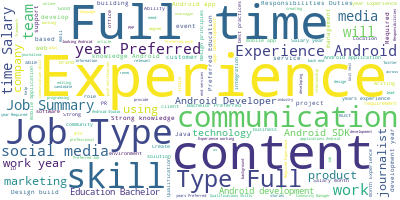

In [8]:

# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed jobs together.
long_string = ','.join(list(job_requirement['job_desc'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Observation:

- In above wordcloud we see the most common words that occur in the job descriptions are Job,skill, year,etc. So we need to remove these words as to get the useful words related to the job. 

### Let's remove some common words that every job description contain. A common words list is provided to you(you can add more). Display top 10 most occuring words.
LDA does not work directly on text data. First, it is necessary to convert the documents into a simple vector representation. This representation will then be used by LDA to determine the topics. Each entry of a 'document vector' will correspond with the number of times a word occurred in the document.

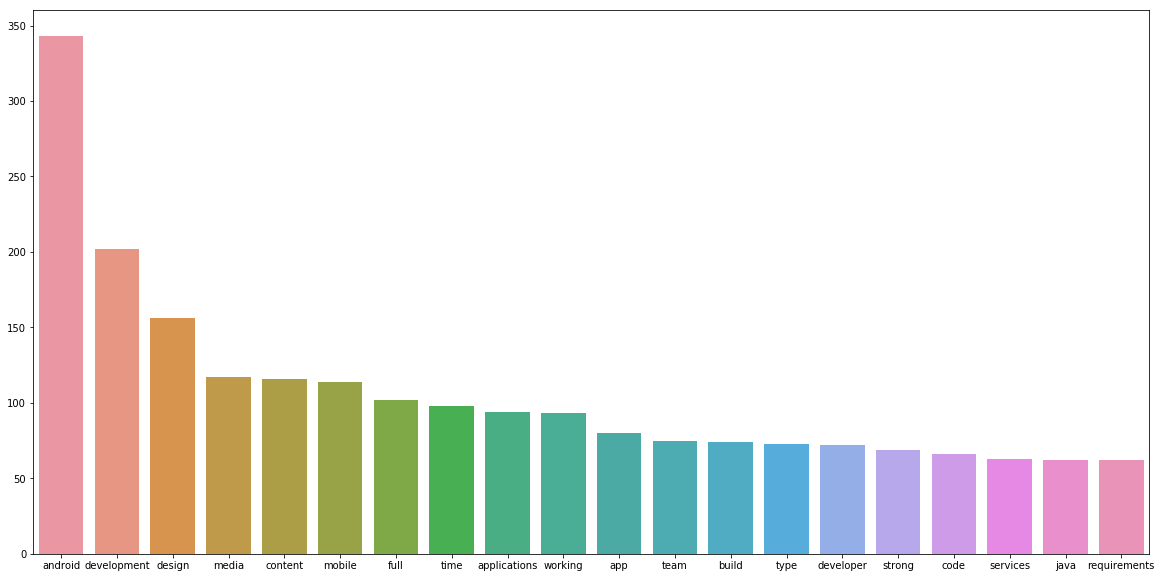

In [9]:
# List of some common words 
stop_set = ['experience','year','years','job','work','knowledge','skills','preferred','required','responsibilities','education','salary','ability']

#  removing stop words
stop = set(stopwords.words('english'))
for word in stop_set:
    stop.add(word)

custom = list(stop)+list(punctuation)

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words=custom , max_features=30000)

# Transform job description
description = vectorizer.fit_transform(job_requirement['job_desc'])

# initialize empty dictionary
words = {}

# initialize with 0
i = 0

# Number of time every feature appears over the entire document
sums = np.array(np.sum(description, axis=0)).flatten()

# Loop to map 'sums' to its word
for word in vectorizer.get_feature_names():
    words[word] = sums[i]
    i += 1

# Top 20 most occuring words
top_20 = sorted(words.items(), key=operator.itemgetter(1), reverse=True)[:20]

# Display top 20 words
top_20_words = [i[0] for i in top_20]
top_20_values = [i[1] for i in top_20]
plt.figure(figsize=(20,10))
sns.barplot(top_20_words,top_20_values)
plt.show()

It seems that now most frequent terms in our data are relevant.

### Perform lowercasing and calculate the frequency of top 10  words. 

In [10]:
# custom stopword list is provided to you in upper task

# Code starts here

# # Converting the rows of column 'job_desc' into a bag of words
BoW = job_requirement["job_desc"].str.lower().tolist()

# Tokenizing the words
BoW = [word_tokenize(x) for x in BoW]

# Flattening the list
BoW = [item for sublist in BoW for item in sublist]

# Removing the stopwords
BoW = [x for x in BoW if x not in custom]

# Initializing wordnet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatizing the bag of words
BoW = [lemmatizer.lemmatize(x) for x in BoW]

# Create a dictionary from the counter
BoW_dict = dict(Counter(BoW))

# Sort the words
sorted_d = sorted(BoW_dict.items(), key=operator.itemgetter(1), reverse=True)

print("\nTop 10 words:\n", sorted_d[:10])

# Code ends here


Top 10 words:
 [('android', 343), ('development', 205), ('design', 165), ('application', 154), ('medium', 122), ('content', 116), ('mobile', 115), ('team', 111), ('technology', 107), ('communication', 102)]


### Model buliding with LSA

In [11]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim.models.lsimodel import LsiModel
from gensim import corpora
from pprint import pprint


exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# Function to lemmatize and remove the stopwords
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in custom])
    punc_free = "".join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# Creating a list of documents from the complaints column
list_of_docs = job_requirement["job_desc"].tolist()

# Implementing the function for all the complaints of list_of_docs
doc_clean = [clean(doc).split() for doc in list_of_docs]
print(doc_clean[:2])

# Code starts here

# Creating the dictionary id2word from our cleaned word list doc_clean
dictionary = corpora.Dictionary(doc_clean)

# Creating the corpus
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Creating the LSi model
lsimodel = LsiModel(corpus=doc_term_matrix, num_topics=2, id2word=dictionary)
pprint(lsimodel.print_topics())



[['core', 'java', 'developer', 'description', 'micro', 'focus', 'everything', 'based', 'simple', 'idea', 'fastest', 'way', 'get', 'result', 'build', 'software', 'solution', 'enable', 'organization', 'secure', 'scalable', 'analytics', 'built', 'bridge', 'gap', 'existing', 'emerging', 'fast', 'tracking', 'digital', 'transformation', 'across', 'devops', 'hybrid', 'security', 'predictive', 'analytics', 'race', 'innovate', 'micro', 'focus', 'customer', 'clear', 'advantage', 'portfolio', 'span', 'following', 'area', 'devops', 'operation', 'cloud', 'security', 'info', 'governance', 'big', 'data', 'machine', 'learning', 'analytics', 'product', 'brief', 'customer', 'demanding', 'comprehensive', 'well', 'integrated', 'identity', 'governance', 'administration', 'iga', 'solution', 'current', 'iga', 'product', 'component', 'disparate', 'way', 'storing', 'operating', 'identity', 'identity', 'associated', 'identity', 'information', 'residing', 'single', 'store', 'modeled', 'iga', 'solution', 'paramou

#### Observation:
- The first topic Topic 0 has terms like ‘android’, ‘development’, ‘mobile’, ‘technology’, indicating that the topic is very much related to Android developer job.
- Topic 1 has terms like ‘medium’, ‘communication’, ‘marketing’, ‘journalist’, indicating that the topic is very much related to Journalist job but we got the term android also which is no were related to Journalist job.

### Model buliding with LDA

In LSA we saw that Topic 1 has some different words which are not related to the Journalist job. Lets see if we can improve our topics by using LDA algorithm.

In [12]:
# imports
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

#doc_clean - Cleaned list containing entries of 'job_desc' column of our dataframe
# This variable is already available.

# Code starts here

# Creating the dictionary id2word from our cleaned word list doc_clean
dictionary = corpora.Dictionary(doc_clean)

# Creating the corpus
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]


# Creating the LDA model
ldamodel = LdaMulticore(corpus=doc_term_matrix, num_topics=2,id2word=dictionary, random_state=20, passes=30, workers= 12)

# printing the topics
pprint(ldamodel.print_topics())

[(0,
  '0.014*"medium" + 0.013*"content" + 0.011*"communication" + 0.007*"social" + '
  '0.006*"team" + 0.006*"marketing" + 0.006*"journalist" + 0.006*"writing" + '
  '0.006*"community" + 0.005*"company"'),
 (1,
  '0.037*"android" + 0.020*"development" + 0.017*"design" + '
  '0.016*"application" + 0.012*"mobile" + 0.009*"developer" + '
  '0.009*"technology" + 0.008*"full" + 0.008*"app" + 0.007*"working"')]


#### Observation:
The first topic Topic 0 has terms like ‘medium’, ‘communication’, ‘marketing’, ‘journalist’, indicating that the topic is very much related to Journalist job. Similarly, Topic 1 seems to be about the Android development job as it has terms like ‘android’, ‘development’,‘mobile’,‘technology’, and ‘design’.

### Analyzing with LDA model

To visualize the topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.

pyLDAvis package is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The interactive visualization pyLDAvis produces is helpful for both:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most freqeuent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.


Here is the documentation for <a href="https://pyldavis.readthedocs.io/en/latest/readme.html">pyLDAvis</a>

In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
1      0.12284  0.0       1        1  51.565231
0     -0.12284  0.0       2        1  48.434769, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
8     Default  289.000000        android  289.000000  30.0000  30.0000
210   Default  130.000000    application  130.000000  29.0000  29.0000
50    Default  139.000000         design  139.000000  28.0000  28.0000
333   Default  105.000000         medium  105.000000  27.0000  27.0000
863   Default  100.000000        content  100.000000  26.0000  26.0000
219   Default  173.000000    development  173.000000  25.0000  25.0000
338   Default   97.000000         mobile   97.000000  24.0000  24.0000
53    Default   69.000000      developer   69.000000  23.0000  23.0000
32    Default   87.000000  communication   87.000000  22.0000  22.0000
495   Default   50.000000           apis   50.000000  21.0000  21.0000
28    Default   56.000000           code   56.000000  20.0000  20.0000
1594  Default   47.000000     journalist   47.000000  19.0000  19.0000
910   Default   43.000000      community   43.000000  18.0000  18.0000
779   Default   52.000000         social   52.000000  17.0000  17.0000
396   Default   44.000000        writing   44.000000  16.0000  16.0000
637   Default   47.000000      marketing   47.000000  15.0000  15.0000
110   Default   52.000000           java   52.000000  14.0000  14.0000
550   Default   44.000000            sdk   44.000000  13.0000  13.0000
209   Default   68.000000            app   68.000000  12.0000  12.0000
105   Default   37.000000    integration   37.000000  11.0000  11.0000
346   Default   39.000000    performance   39.000000  10.0000  10.0000
1591  Default   31.000000          event   31.000000   9.0000   9.0000
1612  Default   30.000000          brand   30.000000   8.0000   8.0000
971   Default   28.000000           news   28.000000   7.0000   7.0000
295   Default   38.000000    familiarity   38.000000   6.0000   6.0000
193   Default   52.000000  understanding   52.000000   5.0000   5.0000
588   Default   27.000000            api   27.000000   4.0000   4.0000
486   Default   30.000000      technical   30.000000   3.0000   3.0000
532   Default   26.000000        library   26.000000   2.0000   2.0000
997   Default   23.000000          story   23.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
904    Topic2   14.077951        channel   14.533682   0.6931  -6.2619
863    Topic2   96.840576        content  100.029961   0.6925  -4.3335
1725   Topic2   17.371862         writer   17.953207   0.6920  -6.0517
1394   Topic2   15.686019     background   16.242279   0.6901  -6.1538
637    Topic2   46.193111      marketing   47.874172   0.6892  -5.0737
1618   Topic2   11.546479      institute   11.967989   0.6891  -6.4601
1656   Topic2   12.334477         indian   12.822104   0.6862  -6.3941
779    Topic2   50.259003         social   52.988148   0.6721  -4.9893
32     Topic2   80.780945  communication   87.983276   0.6395  -4.5148
965    Topic2   23.410774        manager   24.782372   0.6680  -5.7533
1339   Topic2   21.835030          hindi   23.073574   0.6698  -5.8230
692    Topic2   28.724276        english   31.599436   0.6296  -5.5488
781    Topic2   18.416473        twitter   19.651863   0.6600  -5.9933
466    Topic2   20.225206         online   22.205221   0.6316  -5.8996
273    Topic2   33.696346        company   41.773964   0.5101  -5.3891
1247   Topic2   20.130569       relevant   23.044271   0.5898  -5.9043
199    Topic2   27.936228           well   36.630531   0.4540  -5.5766
42     Topic2   28.357780       customer   37.478531   0.4461  -5.5616
277    Topic2   29.310011         degree   41.698723   0.3724  -5.5286
380    Topic2   46.698673           team   94.965546   0.0152  -5.0628
33